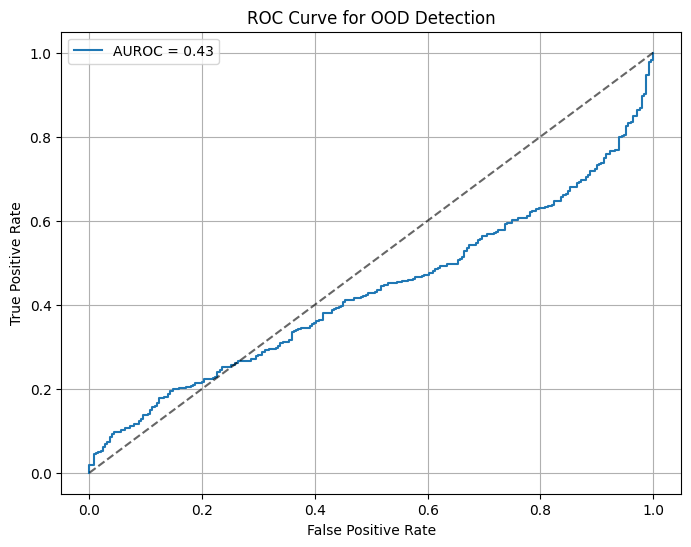

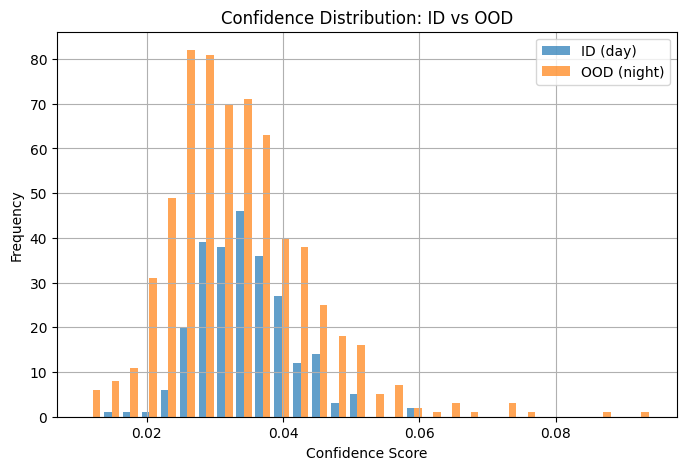

In [2]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
id_path = r"D:\ODD PROJECT\DATA\BDD\scene_classification\id"
ood_path = r"D:\ODD PROJECT\DATA\BDD\scene_classification\ood"

# Load model
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("../models/resnet18_id_only.pth", map_location=device))
model = model.to(device)
model.eval()

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
id_dataset = datasets.ImageFolder(root=id_path, transform=transform)
ood_dataset = datasets.ImageFolder(root=ood_path, transform=transform)

id_loader = DataLoader(id_dataset, batch_size=1, shuffle=False)
ood_loader = DataLoader(ood_dataset, batch_size=1, shuffle=False)

# Softmax/sigmoid for binary score
activation = nn.Sigmoid()

# Store scores and labels
all_scores = []
all_labels = []

# In-Distribution (label = 0)
with torch.no_grad():
    for img, _ in id_loader:
        img = img.to(device)
        score = activation(model(img)).item()
        all_scores.append(score)
        all_labels.append(0)

# Out-of-Distribution (label = 1)
with torch.no_grad():
    for img, _ in ood_loader:
        img = img.to(device)
        score = activation(model(img)).item()
        all_scores.append(score)
        all_labels.append(1)

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for OOD Detection")
plt.legend()
plt.grid(True)
plt.show()

# Histogram (Confidence Distribution)
plt.figure(figsize=(8, 5))
plt.hist([all_scores[:len(id_dataset)], all_scores[len(id_dataset):]],
         bins=30, label=['ID (day)', 'OOD (night)'], alpha=0.7)
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Confidence Distribution: ID vs OOD")
plt.legend()
plt.grid(True)
plt.show()
